# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

## Откроем файл с данными и изучите общую информацию

In [591]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [592]:
data = pd.read_csv('real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [593]:
display(data.head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


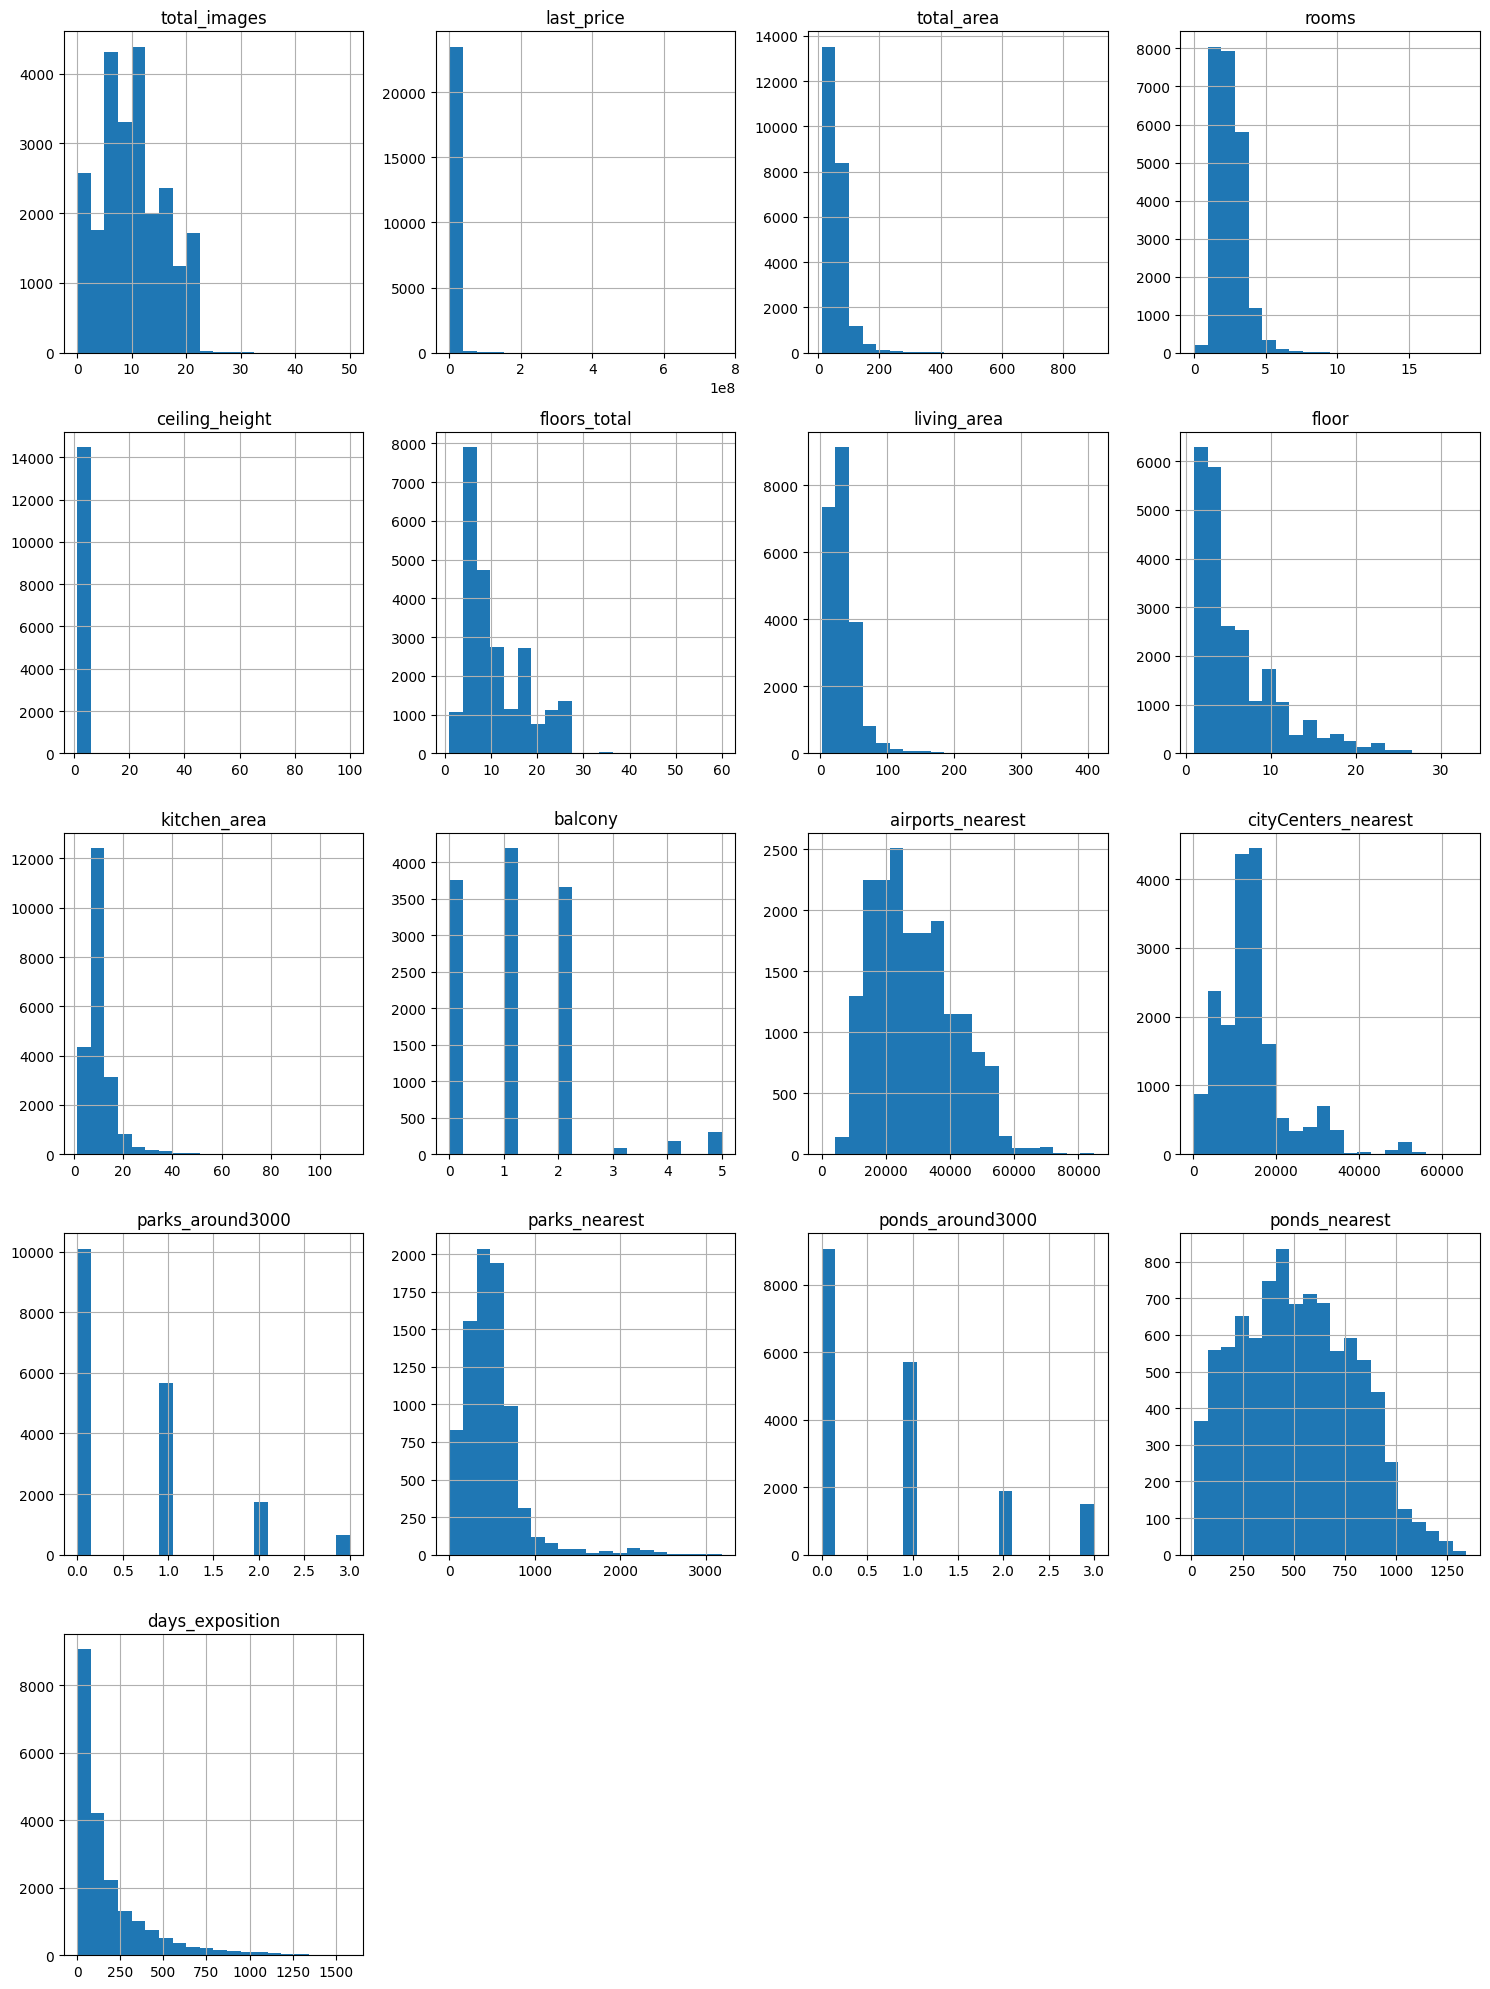

In [594]:
# Создаем гистограммы для числовых столбцов датафрейма
data.hist(figsize=(15, 20), bins=20)
# Настраиваем расстояния между графиками для лучшей читабельности
plt.tight_layout()
plt.show()

## Выполним предобработку данных

In [595]:
print(data.isna().sum()) #находим столбики с пропусками

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


**Данные о балконах:**
т.к. продавец не указал количество балконов в своей квартире, то, скорее всего, их нет. Такие пропуски мы заменим на число 0.

In [596]:
data['balcony'] = data['balcony'].fillna(value='0')
print(data['balcony'].isna().sum())

0


**Данные о парках и прудах:**
Тут также, как и делали выше, если продавец не указал никакой информации о количестве прудов и парков около дома, заменим все пропуски на значение 0

In [597]:
data['parks_around3000'] = data['parks_around3000'].fillna(value='0')
data['parks_nearest'] = data['parks_nearest'].fillna(value='0')
print(data['parks_around3000'].isna().sum())
print(data['parks_nearest'].isna().sum())

0
0


In [598]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(value='0')
data['ponds_nearest'] = data['ponds_nearest'].fillna(value='0')
print(data['ponds_around3000'].isna().sum())
print(data['ponds_nearest'].isna().sum())

0
0


**Данные об апартаментах:** если люди не указали эти данные, будем считать что все пропуски обозначают, что это не апартаменты (на дальшейшие вычисления это не повлияет)

In [599]:
data['is_apartment'].fillna(False, inplace=True) # заменим все значения NaN на False

**Данные о высоте потолков:** заменим пустые значения Nan в столбце ceiling_height на медианные значения 

In [600]:
median_ceiling_height = data['ceiling_height'].median() #cоздаем переменную с медианными значениями высоты потолка 
data['ceiling_height'].fillna(median_ceiling_height, inplace=True)

**Данные об этажности дома и названии населённого пункта:** 
Удалим значения Nan в стобиках floors_total и locality_name, т.к. данные пропуски состаляют маленький процент от всего датасета и на дальнейшие вычисления сильно влиять не будут

In [601]:
data = data.dropna(subset=['locality_name', 'floors_total'])

**Данные о жилой площади:**   
Посчитаем отношения жилых площадей к общим, возьмем средний коэффициент отношения и с его помощью восстановим пропуски

In [602]:
ratio_of_areas_living = (data['living_area'] / data['total_area']).mean()
print('Средний коэффициент отношения равен', round(ratio_of_areas_living,2))

Средний коэффициент отношения равен 0.56


In [603]:
fill_living_area = data['total_area']*ratio_of_areas_living
data['living_area'] = data['living_area'].fillna(value=fill_living_area)
print(data['living_area'])

0        51.000000
1        18.600000
2        34.300000
3        89.825011
4        32.000000
           ...    
23694    73.300000
23695    38.000000
23696    29.700000
23697    43.358928
23698    12.300000
Name: living_area, Length: 23565, dtype: float64


**Данные о площади кухни:**   
Как и делали выше, посчитаем отношения площадей кухонь к общим и восстановим пропуски

In [604]:
ratio_of_areas_kitchen = (data['kitchen_area'] / data['total_area']).mean()
print('Средний коэффициент отношения равен', round(ratio_of_areas_kitchen,2))

Средний коэффициент отношения равен 0.19


In [605]:
fill_kitchen_area = data['total_area']*ratio_of_areas_kitchen
data['kitchen_area'] = data['kitchen_area'].fillna(value=fill_kitchen_area)
print(data['kitchen_area'])

0        25.000000
1        11.000000
2         8.300000
3        29.786996
4        41.000000
           ...    
23694    13.830000
23695     8.500000
23696    10.622155
23697    23.300000
23698     9.000000
Name: kitchen_area, Length: 23565, dtype: float64


In [606]:
print(data.isna().sum())

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest        5524
cityCenters_nearest     5501
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition         3171
dtype: int64


**Для оставшихся значений, а именно:**
    
 -расстояние до ближайшего аэропорта в метрах;  
 -расстояние до центра города;  
 -сколько дней было размещено объявление (от публикации до снятия)

Пропуски оставляем без изменений, потому что логичную замену предложить невозможно.

**Возможные причины пропусков в данных:**

Значения расстояний до аэропорта или же до центра города могли быть не указаны, потому что квартиры скорее всего находятся в поселках и деревнях, которые очень сильно отдалены от аэропорта или же больших городов. Остальные параменты продавец мог не ввести по невнимательности или же не знанию при заполнении документов.



**Изменяем тип данных:** Значения количества парков, количесва прудов и балконов меням с типа float на тип int, т.к. данные значения должны быть целыми числами. Названия населенных пунктов же меняет на тип str. 

In [607]:
data.loc[:,'parks_around3000'] = data.loc[:,'parks_around3000'].astype('int')
data.loc[:,'ponds_around3000'] = data.loc[:,'ponds_around3000'].astype('int')
data.loc[:,'balcony'] = data.loc[:,'balcony'].astype('int')
data.loc[:,'locality_name'] = data.loc[:,'locality_name'].astype('str')

In [608]:
print(sorted(data['locality_name'].unique()))

['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг', 'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск', 'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар', 'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле', 'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское', 'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво', 'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург', 'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор', 'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург', 'городской поселок Большая Ижора', 'городской поселок Янино-1', 'городской посёлок Будогощь', 'городской посёлок Виллози', 'городской посёлок Лесогорский', 'городской посёлок Мга', 'городской посёлок Назия', 'городской посёлок Новоселье', 'городской посёлок Павлово', 'городской посёлок Рощино', 'городской посёлок Свирьстрой', 'городской посёлок Советский', 'городской посёлок Фёдоровское', 'городской посёлок Янино-1', 'деревня Агалатово', 'деревня Аро',

In [609]:
print(len(data['locality_name'].unique()))

364


In [610]:
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['городской поселок', 'городской посёлок'], 'поселок городского типа', regex=True)
    .replace(['коттеджный поселок','коттеджный посёлок'],'поселок' , regex=True)
    .replace(['посёлок станции', 'поселок при железнодорожной станции', 'посёлок при железнодорожной станции'], 'поселок станции', regex=True)
    .replace(['поселок Громово'], 'поселок станции Громово', regex=True)
    .replace(['Кудрово'], 'деревня Кудрово', regex=True)
    .replace(['Никольское'], 'село Никольское', regex=True)
    .replace(['село село'], 'село', regex=True)
    .replace(['деревня деревня'], 'деревня', regex=True)
) #избавляемся от неявных дубликатов

In [611]:
print(len(data['locality_name'].unique()))

317


Мы обработали 47 дубликатов

## Добавим в таблицу новые столбцы

In [612]:
data['price_per_meter'] = data['last_price'] / data['total_area'] 
data['price_per_meter'] = round(data['price_per_meter'],2) #цена одного квадратного метра
print(data['price_per_meter'].head(5))

0    120370.37
1     82920.79
2     92785.71
3    408176.10
4    100000.00
Name: price_per_meter, dtype: float64


In [613]:
# Преобразуем в формат datetime без указания формата
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])
# Извлекаем день недели
data['weekday'] = data['first_day_exposition'].dt.weekday
# Вывод первых 5 значений
print(data['weekday'].head(5))

0    3
1    1
2    3
3    4
4    1
Name: weekday, dtype: int32


In [614]:
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month 
print(data['month'].head(5)) # месяц публикации объявления

0     3
1    12
2     8
3     7
4     6
Name: month, dtype: int32


In [615]:
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year 
print(data['year'].head(5)) # год публикации объявления

0    2019
1    2018
2    2015
3    2015
4    2018
Name: year, dtype: int32


In [616]:
def floor_type(row): # создайем функцию floor_type()
    floor = row['floor'] 
    floors_total = row['floors_total']
    
    if floor == 1:
        return 'первый'
    if floor == floors_total:
        return 'последний'
    if 1 < floor < floors_total:
        return 'другой' # тип этажа квартиры (значения — «первый», «последний», «другой»)

In [617]:
data['total_floor_type'] = data.apply(floor_type,axis=1) # применяем функцию методом apply()
print(data['total_floor_type'].head(5))

0    другой
1    первый
2    другой
3    другой
4    другой
Name: total_floor_type, dtype: object


In [618]:
data['distance_cityCenters_nearest'] = data['cityCenters_nearest'] / 1000
data['distance_cityCenters_nearest'] = round(data['distance_cityCenters_nearest'], 0)
print(data['distance_cityCenters_nearest'].head(5))
#расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений).

0    16.0
1    19.0
2    14.0
3     7.0
4     8.0
Name: distance_cityCenters_nearest, dtype: float64


## Проведем исследовательский анализ данных

**1) Данные об общей площади:**

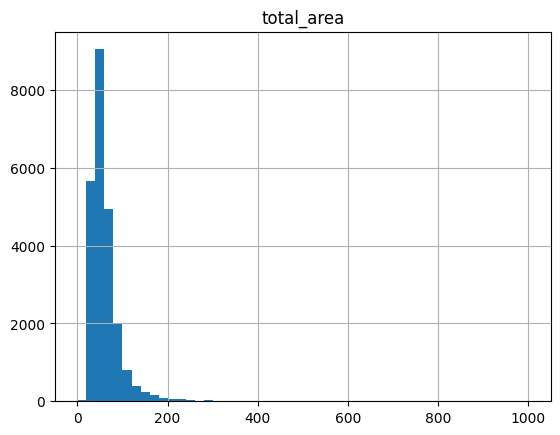

In [619]:
data.hist('total_area', bins=50, range=(0, 1000))
plt.show()

In [620]:
print(data['total_area'].describe())

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64


По данным видно, что подавляющее большинство квартир приходится примерно на промежуток от 20м2 до 250м2. А пик приходится на площадь квартир от 40-70м2. Поэтому, удалим значения, которые сильно выбиваются из общего числа.

In [621]:
data = data[(data['total_area'] <= 300)]

**2) Данные о жилой площади:**

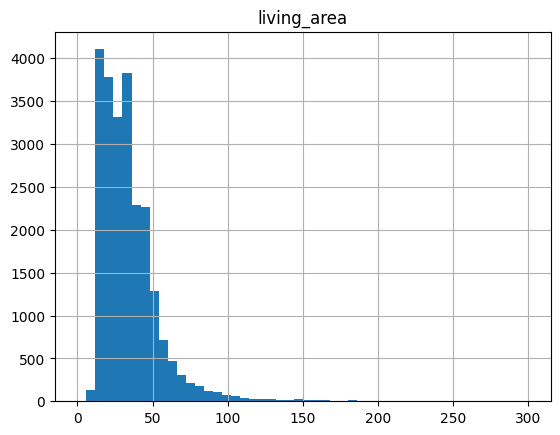

In [622]:
data.hist('living_area', bins=50, range=(0, 300))
plt.show()

In [623]:
print(data['living_area'].describe())

count    23504.000000
mean        34.055738
std         19.764392
min          2.000000
25%         19.000000
50%         30.000000
75%         42.000000
max        250.000000
Name: living_area, dtype: float64


По данным и гистограмме видно, что межквартильный размах (расстояние между Q1 и Q3) находится в промежутке от 19-42м2. Удалим редкие значения которые не повлияют на датасет:

In [624]:
data = data[(data['living_area']>=10) & (data['living_area'] <= 200)]

**3) Данные о площади кухни:**

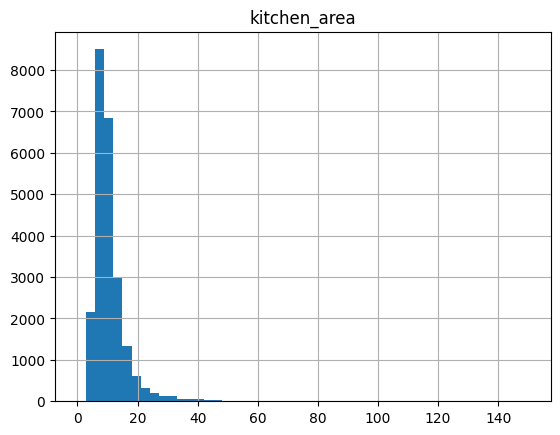

In [625]:
data.hist('kitchen_area', bins=50, range=(0, 150))
plt.show()

In [626]:
print(data['kitchen_area'].describe())

count    23469.000000
mean        10.465589
std          5.685599
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64


Из данных мы видим что большинство квартир имеют небольшие кухни, в среднем 7-12м2. 

**4) Данные о цене объекта:**

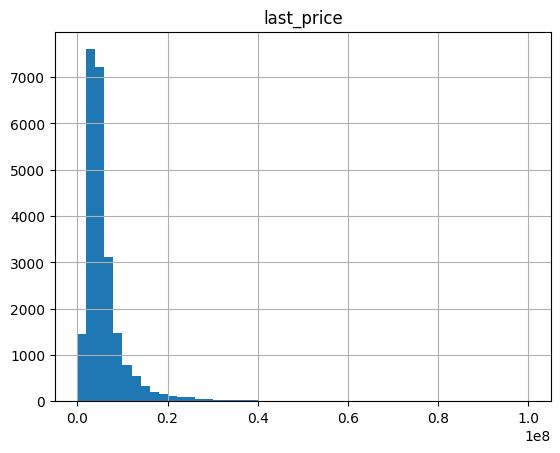

In [627]:
data.hist('last_price', bins=50, range=(12000, 100000000))
plt.show()

In [628]:
print(data['last_price'].describe())

count    2.346900e+04
mean     6.292573e+06
std      7.703178e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.750000e+06
max      3.300000e+08
Name: last_price, dtype: float64


Средняя стоимость квартир варьируется от 3.4 до 6.7 млн.руб. Уберем очень маленькую стоимость квартиры и выбросы с очень большой стоимостью квартиры.

In [629]:
data = data[(data['last_price']!=12190) & (data['last_price'] <= 60000000)]

**5) Данные о количестве комнат:**

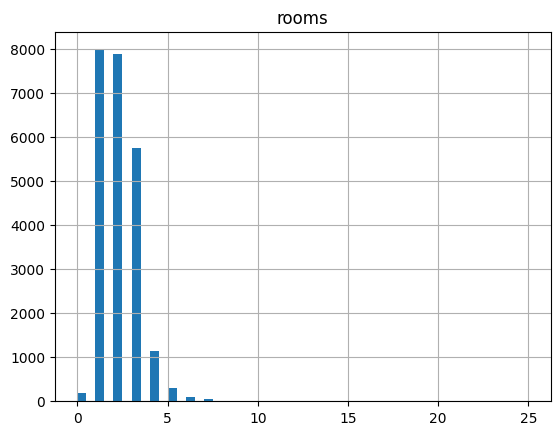

In [630]:
data.hist('rooms', bins=50, range=(0, 25))
plt.show()

In [631]:
print(data['rooms'].describe())

count    23400.000000
mean         2.053462
std          1.037568
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: rooms, dtype: float64


Около 8.000 квартир имеют 1 или 2 комнаты. Удалим квартиры где указано 0 комнат, и квартиры с сильно выбиващимися значениями. 

In [632]:
data = data[(data['rooms']!=0) & (data['rooms'] <= 10)]

**6) Данные о высоте потолков:**

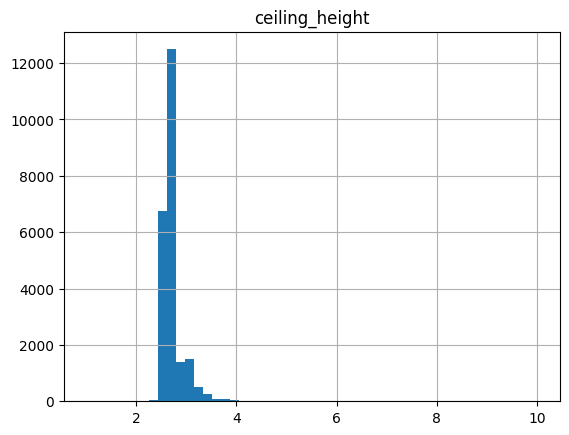

In [633]:
data.hist('ceiling_height', bins=50, range=(1, 10))
plt.show()

In [634]:
print(data['ceiling_height'].describe())

count    23205.000000
mean         2.720847
std          0.983669
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64


Как мы видим, в данных присутствуют аномалии. Необходимо обработать их и убрать выбивающиеся значения.

In [635]:
data['ceiling_height'] = (
    data['ceiling_height']
    .replace(['20.0'], '2.0', regex=True)
    .replace(['22.6'], '2.26', regex=True)
    .replace(['24.0'], '2.4', regex=True)
    .replace(['25.0'], '2.5', regex=True)
    .replace(['26.0'], '2.6', regex=True)
    .replace(['27.0'], '2.7', regex=True)
    .replace(['27.5'], '2.75', regex=True)
    .replace(['32.0'], '3.2', regex=True)
    .replace(['100.0'], '10.0', regex=True)
)

In [636]:
data = data[(data['ceiling_height']>=2) & (data['ceiling_height'] <= 6)]

**7) Данные о типе этажа квартир:**

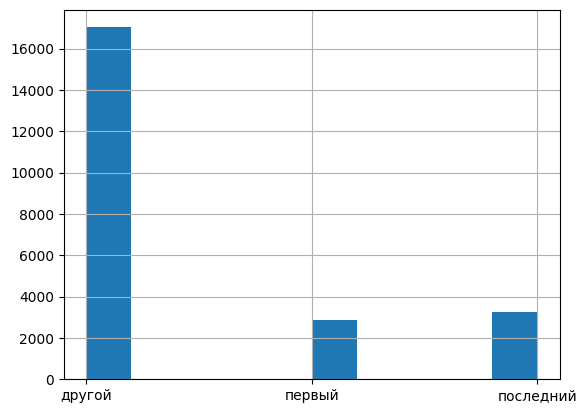

In [637]:
data['total_floor_type'].hist()
plt.show()

Как и ожидалось, 'других' этажей оказалось в разы больше, чем первых и последних.

**8) Данные об общем количестве этажей в доме:**

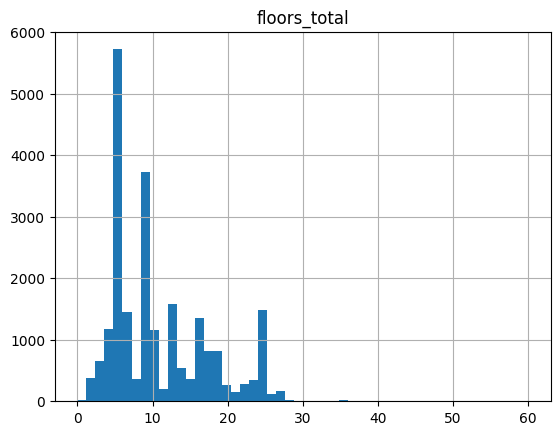

In [638]:
data.hist('floors_total', bins=50, range=(0, 60))
plt.show()

In [639]:
print(data['floors_total'].describe())

count    23174.000000
mean        10.645681
std          6.569519
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


Люди выставили на продажу квартиры как и в малоэтажных домах, так и в высотных. Больше всего квартир в 5-и этажных домах. Так же, как и делали выше, уберем выбивающиеся значения от общей массы.

In [640]:
data = data[(data['floors_total']<=40)]

**9) Данные о расстоянии до центра города в метрах:**

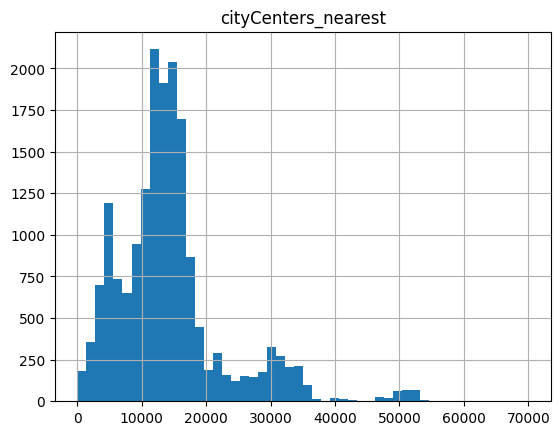

In [641]:
data.hist('cityCenters_nearest', bins=50, range=(0, 70000))
plt.show()

In [642]:
print(data['cityCenters_nearest'].describe())

count    17762.000000
mean     14261.259768
std       8617.600389
min        181.000000
25%       9377.000000
50%      13138.000000
75%      16299.750000
max      65968.000000
Name: cityCenters_nearest, dtype: float64


Большинство квартир находятся в непосредсвенной близости к центру города (в среднем 9-16км от него), но есть и те, которые находятся и на большом расстоянии.

**10) Данные о расстоянии до ближайшего парка:**

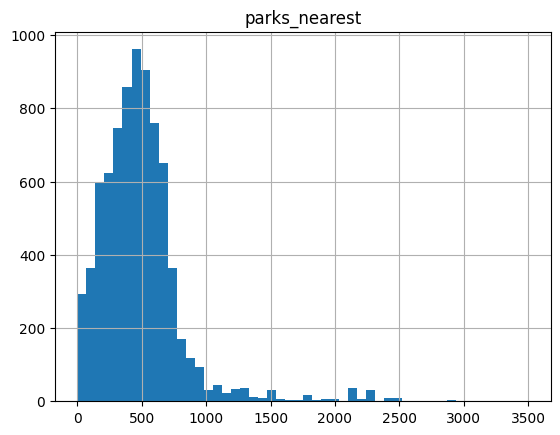

In [643]:
data['parks_nearest'] = pd.to_numeric(data['parks_nearest'], errors='coerce')
data_filtered = data.dropna(subset=['parks_nearest'])
data_filtered.hist('parks_nearest', bins=50, range=(1, 3500))
plt.show()

У большинства квартир не указано расстояние до парков. Рассмотрим данные, где указаны расстояния. Как видно из графика, пик квартир приходится на расстояние примерно 400-600м до парка. Удалим сильно выбивающиеся значения.

In [644]:
data = data[(data['parks_nearest']<=2000)]

In [645]:
print(len(data))

23060


Как мы видим, после всех преобразований, от исходного датасета в котором содержалось 23.699 записей, у нас осталось 23.060 записей. Количество удаленных объявлений составлят всего 2.7% от общего числа.

**Изучим, как быстро продавались квартиры**

Рассмотрим параметр days_exposition:

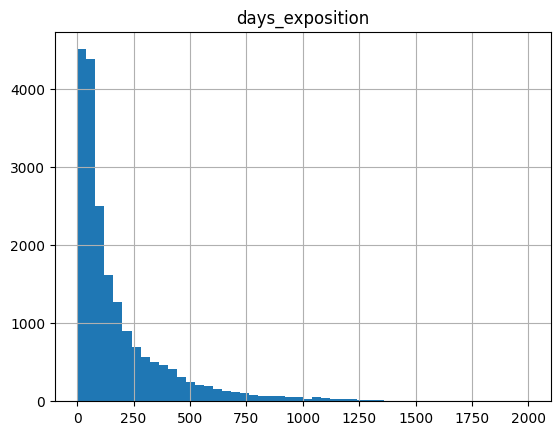

Среднее значение равно  180.00415977547237

Медиана равна  95.0

count    19953.00000
mean       180.00416
std        218.48959
min          1.00000
25%         45.00000
50%         95.00000
75%        230.00000
max       1580.00000
Name: days_exposition, dtype: float64


In [646]:
data.hist('days_exposition', bins=50, range=(1, 2000))
plt.show()
print('Среднее значение равно ', data['days_exposition'].mean())
print()
print('Медиана равна ', data['days_exposition'].median())
print()
print(data['days_exposition'].describe())

Как видно из данных, обычно продажа квартир занимает от 1.5 до 7.5 месяцев. Также, у нас есть как и быстрые продажи квартир, так и необычайно долгие. Все квартиры до первого квартиля можно назвать быстрыми продажами (до 45 дней). Долгими же продажами будут считаться все, которые находятся после 3 квартиля (после 230 дней).

**Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта**

**1) Зависимость цены от общей площади:**

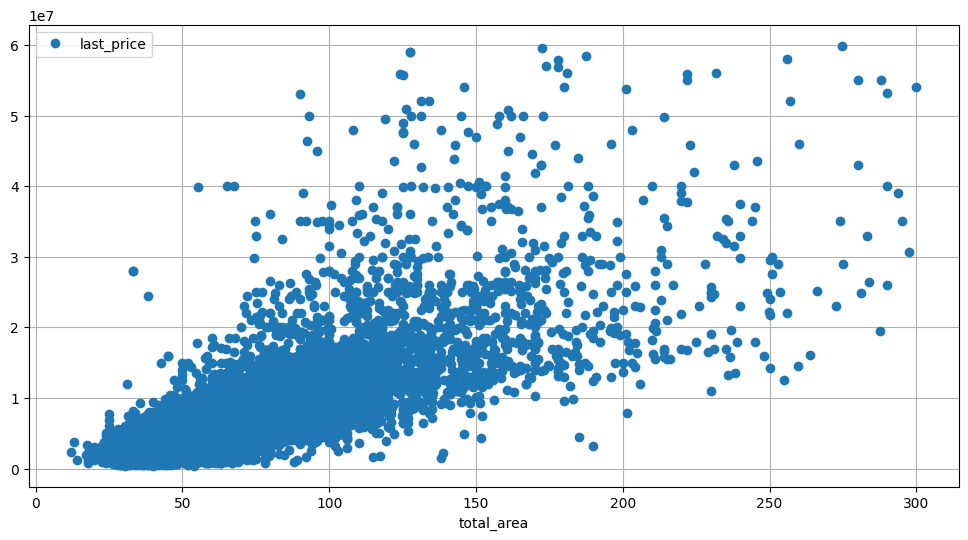

In [647]:
data.plot(x='total_area', y='last_price', grid=True, figsize=(12, 6),style='o')
plt.show()

In [648]:
print('Коэффициент корреляции равен', data['total_area'].corr(data['last_price']))

Коэффициент корреляции равен 0.7752812099413493


В случае, если с ростом первой величины растёт и вторая, то коэффициент корреляции Пирсона — положительный. Корреляция в 0.77 говорит о наличии связи между ценой и площадью квартиры. Это и подтверждаени график, чем больше становится площадь, тем сильнее возрастает цена. 

**2) Зависимость цены от жилой площади:**

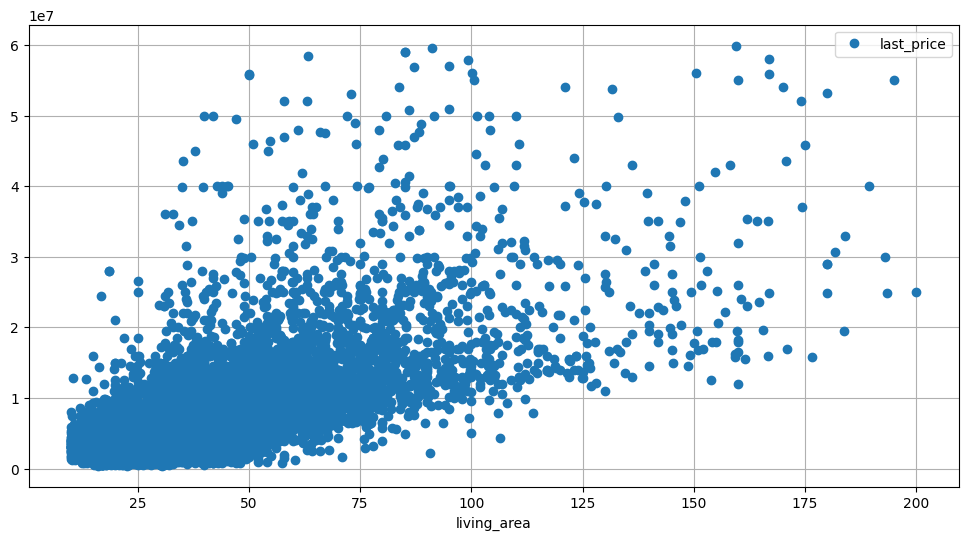

In [649]:
data.plot(x='living_area', y='last_price', grid=True, figsize=(12, 6),style='o')
plt.show()

In [650]:
print('Коэффициент корреляции равен', data['living_area'].corr(data['last_price']))

Коэффициент корреляции равен 0.6830408817708975


Тут также, как и в примере выше, цена увеличивается с увеличением жилой площади. Коэффициент корреляции Пирсона равен 0,68 что также говорит о наличии связи, однако слабее чем у общей площади.

**3) Зависимость цены от площади кухни:**

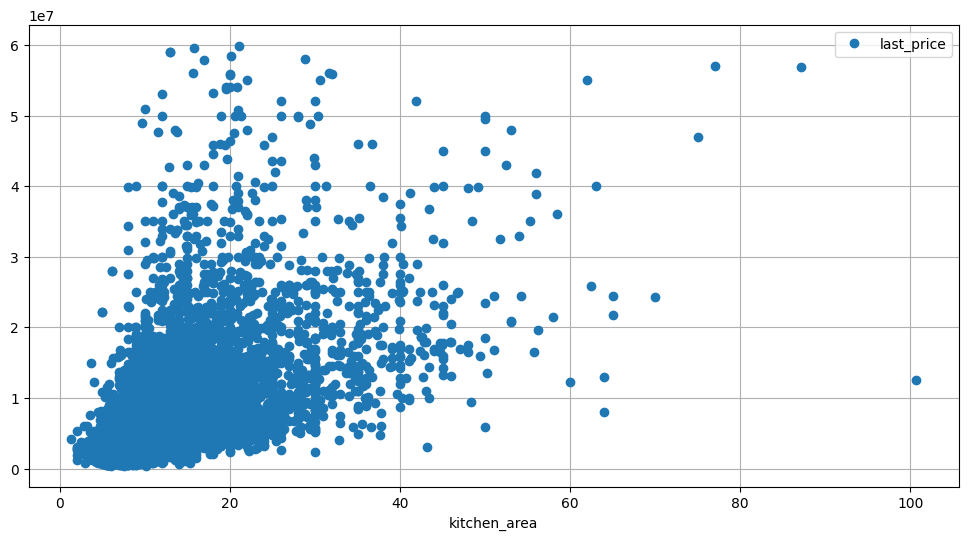

In [651]:
data.plot(x='kitchen_area', y='last_price', grid=True, figsize=(12, 6),style='o')
plt.show()

In [652]:
print('Коэффициент корреляции равен', data['kitchen_area'].corr(data['last_price']))

Коэффициент корреляции равен 0.6093874074479647


Здесь также присутствует зависимость цены от площади кухни, но уже не такая сильная как в предыдущих двух примерах, т.к. коэффициент стал меньше

**4) Зависимость цены от количества комнат:**

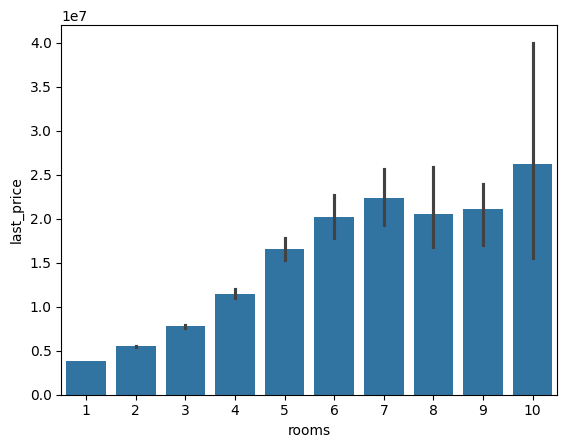

In [653]:
sns.barplot(x = 'rooms', y = 'last_price', data = data)
plt.show()

In [654]:
print('Коэффициент корреляции равен', data['rooms'].corr(data['last_price']))

Коэффициент корреляции равен 0.48983884004015


Как и ожидалось, цена однокомнатной или двухкомнатной квартриры в разы меньше квартир с 4мя и более комнатами. Но корреляция в 0.49 говорит о наличии связи, однако не слишком сильной.

**5) Зависимость цены от типа этажа:**

                    last_price
total_floor_type              
другой            6.280631e+06
первый            4.662643e+06
последний         5.864739e+06


<Axes: xlabel='total_floor_type'>

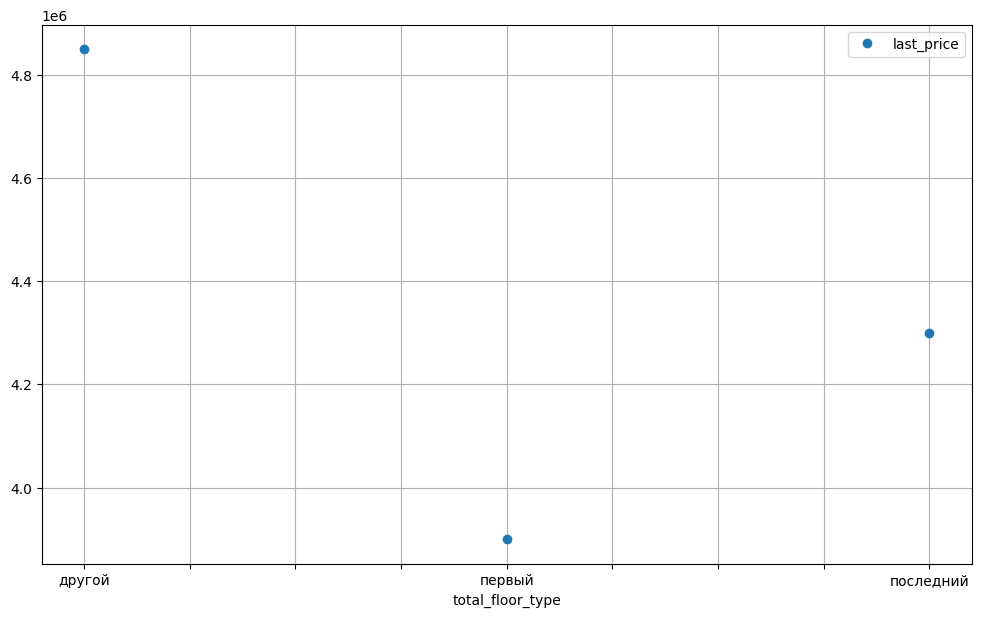

In [655]:
price_on_total_floor_type = data.pivot_table(index='total_floor_type', values='last_price')
print(price_on_total_floor_type)

median_price_on_total_floor_type = data.pivot_table(index='total_floor_type', values='last_price', aggfunc='median')
median_price_on_total_floor_type.plot(grid=True, figsize=(12, 7), style='o')

Квартиры на первом этаже продаются во много раз дешевле, чем на других или же последних этажах. 

**6) Зависимость цены от даты публикации:**

           last_price
weekday              
0        6.119489e+06
1        6.004082e+06
2        6.085647e+06
3        6.230460e+06
4        5.888504e+06
5        5.749662e+06
6        5.790603e+06
Axes(0.125,0.11;0.775x0.77)
         last_price
month              
1      6.172168e+06
2      6.039948e+06
3      5.929394e+06
4      5.961602e+06
5      5.946185e+06
6      5.836694e+06
7      6.015329e+06
8      6.053959e+06
9      6.068295e+06
10     5.839094e+06
11     6.225435e+06
12     6.192639e+06
Axes(0.125,0.11;0.775x0.77)
        last_price
year              
2014  1.077624e+07
2015  7.298319e+06
2016  6.123261e+06
2017  5.932314e+06
2018  5.720506e+06
2019  6.334681e+06
Axes(0.125,0.11;0.775x0.77)


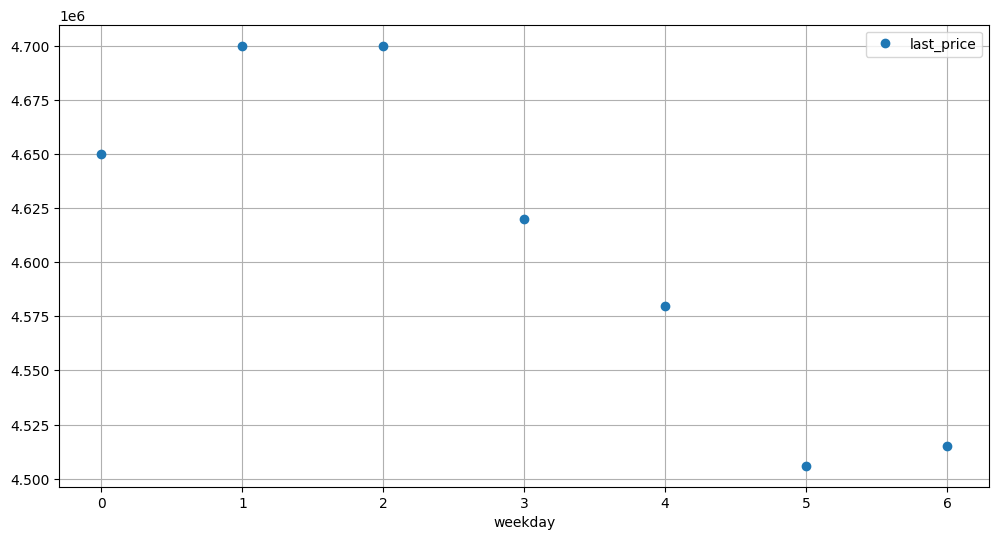

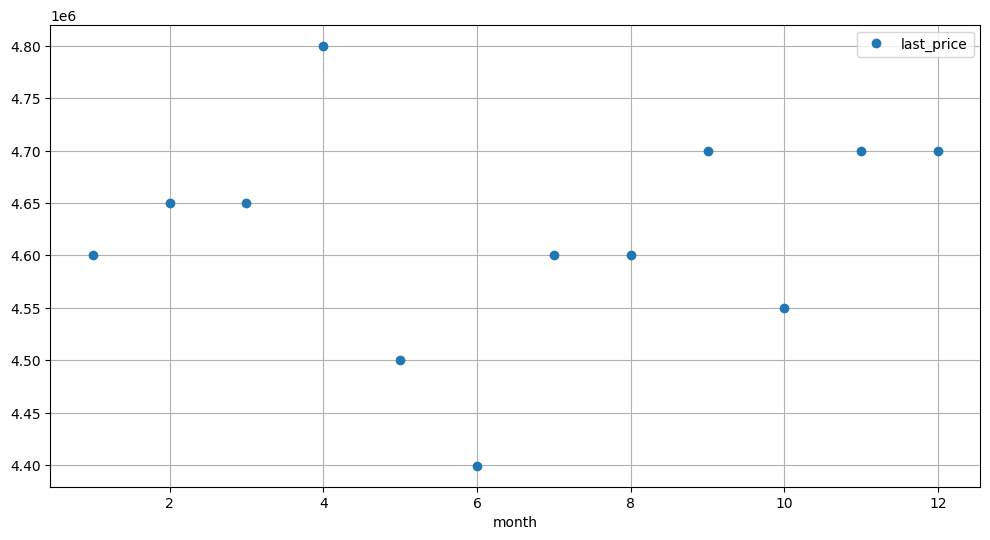

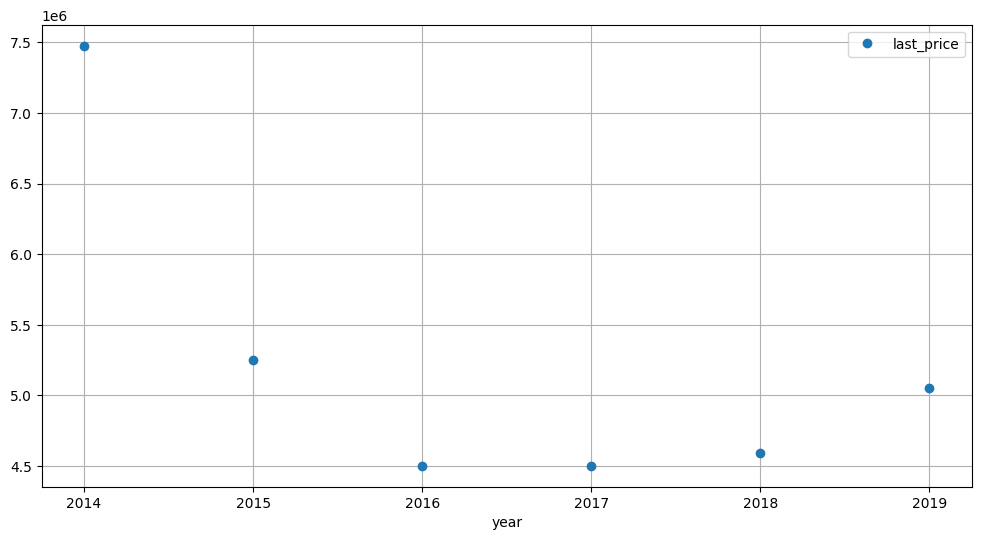

In [656]:
price_on_weekday = data.pivot_table(index='weekday', values='last_price')
print(price_on_weekday)
print(data

    .pivot_table(index='weekday', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(12, 6),style='o')
)

price_on_month = data.pivot_table(index='month', values='last_price')
print(price_on_month)
print(data

    .pivot_table(index='month', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(12, 6),style='o')
)

price_on_year = data.pivot_table(index='year', values='last_price')
print(price_on_year)
print(data

    .pivot_table(index='year', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(12, 6),style='o')
)

Из данных мы можем сделать вывод, что цены по выходным дням указаны ниже, чем по будням.  
Также, как мы видим из графиков, что цены на квартиры к летнему периоду резко падают, а к зимнему возрастают.  
Пик цен приходился на 2014 год, далее ценник на квартиры упал и минимум был зафиксирован в 2017 году.

**Средняя цена одного квадратного метра**

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [657]:
top_ten_city = data.pivot_table(index='locality_name', values='last_price', aggfunc='count')
top_ten_city = top_ten_city.rename(columns={'last_price':'count'})
top_ten_city = top_ten_city.sort_values(by='count', ascending=False)
print(top_ten_city)

                  count
locality_name          
Санкт-Петербург   15253
поселок Мурино      525
деревня Кудрово     449
поселок Шушары      434
Всеволожск          392
...                 ...
деревня Пустынка      1
деревня Хязельки      1
деревня Пчева         1
деревня Хапо-Ое       1
село Шум              1

[314 rows x 1 columns]


In [658]:
price_per_meter_in_city = data.pivot_table(index='locality_name', values='price_per_meter', aggfunc='mean')
print(price_per_meter_in_city)

                      price_per_meter
locality_name                        
Бокситогорск             17551.591250
Волосово                 40183.326111
Волхов                   35055.143727
Всеволожск               68618.013724
Выборг                   58141.909325
...                               ...
село Путилово            39921.755000
село Рождествено         37733.160000
село Русско-Высоцкое     54833.727778
село Старая Ладога       34696.970000
село Шум                 33898.310000

[314 rows x 1 columns]


In [659]:
total_top_ten_city = top_ten_city.merge(price_per_meter_in_city, on='locality_name')

In [660]:
print(total_top_ten_city.sort_values('count', ascending=False).head(10)) 
#найдем 10 городов с самым большим количеством объявлений

                   count  price_per_meter
locality_name                            
Санкт-Петербург    15253    112292.475592
поселок Мурино       525     85066.690476
деревня Кудрово      449     95083.103786
поселок Шушары       434     78303.212696
Всеволожск           392     68618.013724
Пушкин               367    103130.851826
Колпино              335     75233.978149
поселок Парголово    323     90289.778019
Гатчина              306     68757.678399
Выборг               237     58141.909325


Как видно из рассчетов выше, населённый пункт с самой высокой стоимостью квадратного метра является Санкт-Петербург. Квадратный метр в Питере в среднем составляет 112.292р.  
А с самой низкой же стоимостью квадратного метра - Выборг. Его квадратный метр составляет 58.141р

**Средняя стоимость квартир в Санкт-Петербурге на разном удалении от центра**

In [661]:
spb_flats = data.query('locality_name == "Санкт-Петербург"') #выделяем квартиры в Санкт-Петербурге

In [662]:
distance_groups = spb_flats.groupby('distance_cityCenters_nearest')['last_price'].mean()
#группируем среднюю стоимость квартир с расстояние до центра

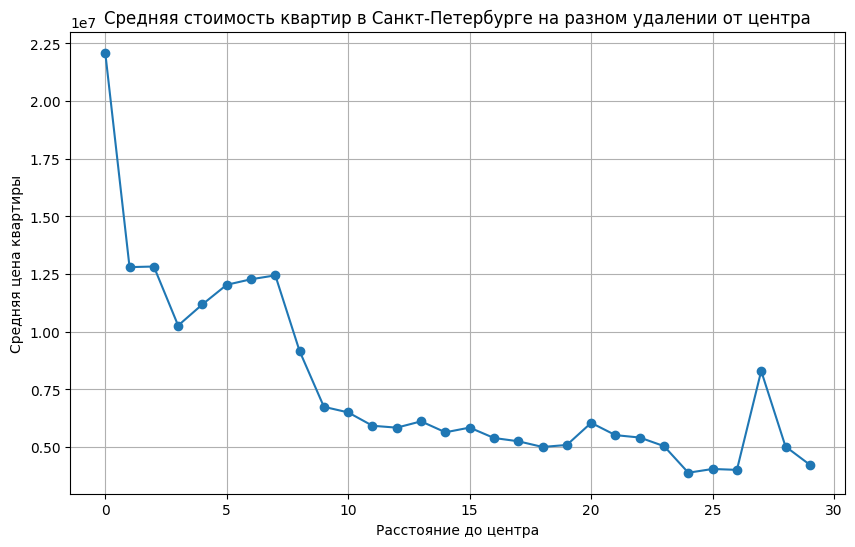

In [663]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
distance_groups.plot(marker='o',linestyle='-')
plt.title('Средняя стоимость квартир в Санкт-Петербурге на разном удалении от центра')
plt.xlabel('Расстояние до центра')
plt.ylabel('Средняя цена квартиры')
plt.grid(True)
plt.show()

Как мы видим из данного графика стоимость объектов напрямую зависит от расстояния до центра города. Как и ожидалось, самые дорогие квартры в центре города. Чем меньше расстояние до центра, тем стоимость квартиры больше. И также, чем дальше квартира от центра Санкт-Петербурга, тем стоимость квартиры меньше.

## Напишем общий вывод

В данной работе мы рассматривали архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Провели исследовательский анализ данных и установили параметры, влияющие на цену квартир. 

Сначала, изучили общую информацию и выполнили предобработку данных. Определили пропуски и заполнили их там, где это возможно. Преобразовали типы данных в интересующих нас столбцах и устранили неявные дубликаты.  

Далее нашей задачей было преобразовать существующую таблицу и добавить несколько столбцов с такими параметрами, как:  
- цена одного квадратного метра (price_per_meter);
- день недели публикации объявления (weekday);
- месяц публикации объявления (month);
- год публикации объявления (year);
- тип этажа квартиры (total_floor_type);
- расстояние до центра города в километрах (distance_cityCenters_nearest).

После мы провели исследовательский анализ данных и выявили, что большинство квартир имеют площадь в среднем 40-70м2, небольшие кухни 7-12м2 и стоимость таких квартир варьируется от 3.5 до 6.7 млн.руб. Почти 8 тысяч объявлений имеют 1 или 2 комнаты и большинство квартир находятся не на первом и не на последнем этажах. Количество объявлений с квартирами на первых и последних этажах в разы меньше. Люди выставляли на продажу квартиры как и в малоэтажных домах, так и в высокоэтажных, но больше всего было 5-и этажок. Квартиры расположены  в средней отдаленности от центра (прим. 9-16км) и в непосредвственной близости большинства домов присутсвуют парки. Все аномалии и выбивающиеся значения мы либо преобразовывали, либо противном случае если этого сделать было невозможно, удаляли их, и для каждого параметра строили гистограммы.  

Также мы обнаружили, что обычно продажа квартир занимала от 1.5 до 7.5 месяцев. Были как быстрые, так и необычайно долгие продажи. 

Кроме того были определены факторы, которые больше всего влияют на общую (полную) стоимость объекта. 
Как видно из расчетов выше, цена имеет прямо пропорциональную зависимость от общей площади квартиры, жилой площади, площади кухни и количества комнат. Чем больше эти параметры, тем цена выше. 
  
В нашем случае, с ростом величины общей площади, растёт и величина цены, а коэффициент корреляции Пирсона — положителен и равен 0.77. Т.к. данное значение находится ближе к 1, чем посчитанные нами значения коэффициентов корреляции у жилой площади (0.68), прощади кухни (0.61) и количества комнат (0.49), значит линейная взаимосвязь в данном случае теснее.

К тому же цена зависит от этажа, на котором расположена квартира, а именно, на первом этаже квартиры продаются в дешевле, чем на последнем или другом этаже. 





Также, размещение объявлений о продажи квартир по будням в зимний период времени более предпочтителен, потому что цена выше, нежели чем по выходным в летний период. А данном архиве пик цен приходился на 2014 год, далее ценник на квартиры упал и минимум был зафиксирован в 2017 году. При анализе мы строили графики, чтобы показать зависимость цены от заданных параметров.

После всех проведенных анализов мы посчитали среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений и построили сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктах. Населённые пункты с самой высокой (112.292р) и низкой (58.141р) стоимостью квадратного метра являются Санкт-Петербург и Выборг соответственно. 

И в завершении мы построили график и выявили зависимость средней стоимости квартир в Санкт-Петербурге на разном удалении от его центра. Оказалось, что стоимость объектов напрямую зависит от расстояния до центра города. Чем меньше расстояние до центра, тем стоимость квартиры больше. И также, чем дальше квартира от центра Санкт-Петербурга, тем стоимость квартиры меньше. 

В дальнейшем, я бы посоветовала обратить внимание на те признаки, которые влияют на быстрые и долгие продажи. Можно проанализировать зависимость количества дней публикации от населенного пунута, площади, количества комнат и т.д. Возможно у нас получится выявить какую-то зависимость или закономерность. Также можно добвить в датасет столбцы, которые отражали бы информацию новое это жилье или вторичка, квартира с ремонтом или присутсивует только чистовая отделка, т.к. большая вероятность того, что цена также будет зависить от этих факторов.
